# Modified REINFORCE

Try to implement the modified REINFORCE version(RLOO) and see if that has lower variance!!

In order to implement this, we are modifying the loss function to only consider mean mRNA (not variance as per trajectory variance is useless)

In [3]:
import numpy as np
import torch
import torch.optim as optim
import os
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [4]:
# Stoichiometric matrix defining the effect of each reaction on the system
stoic_matrix = torch.tensor([[2.0, 0.0],    # Reaction 1: Promoter state goes from -1 to +1
                             [0.0, 1.0],    # Reaction 2: mRNA is produced
                             [-2.0, 0.0],   # Reaction 3: Promoter state goes from +1 to -1
                             [0.0, -1.0]])  # Reaction 4: Degradation of mRNA

device = 'cpu'

def propensities(levels, poff, r, g):
    promoter, mRNA = levels
    k_on = (1.0 - poff) / poff

    # Use `.float()` and ensure all terms are 0-dim tensors
    a1 = (k_on * (promoter == -1).float()).reshape(())
    a2 = (r * (promoter == -1).float()).reshape(())
    a3 = (1.0 * (promoter == +1).float()).reshape(())
    a4 = (g * mRNA).reshape(())

    return torch.stack([a1, a2, a3, a4])

def run_trajectories(poff, r, g):
    all_trajectories = []
    final_states = []
    
    for _ in range(num_simulations):
        levels = torch.tensor([-1.0, 0.0], device=device)
        t = 0.0
        trajectory = []

        while t < sim_time:
            a = torch.relu(propensities(levels, poff, r, g))
            a0 = a.sum()

            #if a0.item() <= 1e-8 or torch.isnan(a0):
            #    break

            tau = -torch.log(torch.rand(1, device=device)) / a0
            probs = a / a0
            j = torch.multinomial(probs, 1).item()

            trajectory.append((levels.clone(), j, tau.item()))
            levels = levels + stoic_matrix[j]
            levels[1] = torch.relu(levels[1])
            t += tau.item()

        all_trajectories.append(trajectory)
        final_states.append(levels[1])

    final_states = torch.stack(final_states)

    return all_trajectories, final_states

        
def RLOO_estimate(poff, r, g, mean_data):
    all_trajectories, final_states = run_trajectories(poff, r, g)
    N = len(all_trajectories)
    eps = 1e-8

    losses = []
    log_grads = []

    for n in range(N):
        trajectory = all_trajectories[n]
        final_mRNA = final_states[n]

        #per-trajectory loss 
        loss_n = (final_mRNA - mean_data)**2
        losses.append(loss_n)

        # Compute score function gradient ∇ log p(τ_n)
        poff_, r_, g_ = poff.clone().detach().requires_grad_(), r.clone().detach().requires_grad_(), g.clone().detach().requires_grad_()
        log_grad = [0.0, 0.0, 0.0]
        
        for (x_prev, j, tau) in trajectory:
            a = torch.relu(propensities(x_prev, poff_, r_, g_))
            a0 = a.sum()
            aj = a[j]
    
            d_aj = torch.autograd.grad(aj, (poff_, r_, g_), retain_graph=True, allow_unused=True)
            d_a0 = torch.autograd.grad(a0, (poff_, r_, g_), retain_graph=True, allow_unused=True)
    
            d_aj = [g if g is not None else torch.tensor(0.0, device=poff.device) for g in d_aj]
            d_a0 = [g if g is not None else torch.tensor(0.0, device=poff.device) for g in d_a0]
    
            aj_safe = aj if aj.abs() > eps else eps
            log_grad_step = [daj_i / aj_safe - tau * da0_i for daj_i, da0_i in zip(d_aj, d_a0)]
    
            log_grad = [sum(x) for x in zip(log_grad, log_grad_step)] if isinstance(log_grad, list) else log_grad_step

        log_grads.append(log_grad)

    #RLOO gradient
    total_loss = torch.sum(torch.stack(losses))
    grad_poff = 0.0
    grad_r = 0.0
    grad_g = 0.0

    for n in range(N):
        baseline = (total_loss - losses[n]) / (N-1)
        advantage = losses[n] - baseline

        #scale the score-function gradient by the RLOO advantage within the loop
        grad_poff += advantage * log_grads[n][0]
        grad_r    += advantage * log_grads[n][1]
        grad_g    += advantage * log_grads[n][2]
    

    # Normalize gradients
    grad_poff /= N
    grad_r    /= N
    grad_g    /= N

    # Also return mean loss for logging
    avg_loss = total_loss / N

    return grad_poff, grad_r, grad_g, avg_loss

# Define a function to write data to a file
def write_to_file(filename, *args):
    with open(filename, 'a') as file:
        file.write(' '.join(map(str, args)) + '\n')

In [7]:
# Load the data from file for 5DL1 promoter 
data=np.load("science_data_5DL1.npy")

# Extract x and y data
x_data = data[:, 0]
y_data = data[:, 1]

# Get unique x values and their corresponding indices
unique_x, unique_indices = np.unique(x_data, return_index=True)

# Extract unique y values based on unique indices
unique_y = y_data[unique_indices]

# Create unique data array with x and y values
unique_data = np.column_stack((unique_x, unique_y))

# Convert mean and variance data to torch tensors
mean_data = torch.from_numpy(unique_data[:, 0]).double()
var_data = mean_data * torch.from_numpy(unique_data[:, 1]).double()

## ADAM Optimizer

In [12]:
# Set seed for reproducibility 
torch.manual_seed(42)

# Define simulation hyperparameters
num_iterations = 250
num_simulations = 100
sim_time = 0.2

poff_values = torch.nn.Parameter(torch.linspace(0.03, 0.97, len(unique_data)))
r = torch.nn.Parameter((1e+2) * torch.rand(1))
g = torch.nn.Parameter((1e+1) * torch.rand(1))
optimizer = optim.Adam([poff_values, r, g], lr = 0.01)

#save to file
filename1 = "RLOO_poff_250.txt"
filename2 = "RLOO_main_250.txt"
if os.path.exists(filename1):
    os.remove(filename1)
if os.path.exists(filename2):
    os.remove(filename2)

for iteration in tqdm(range(num_iterations)):
    optimizer.zero_grad()

    grad_poff = torch.zeros_like(poff_values)
    grad_r = torch.zeros_like(r)
    grad_g = torch.zeros_like(g)
    total_loss = 0.0

    for i in range(len(unique_data)):
        dp, dr, dg, loss = RLOO_estimate(poff_values[i], r, g, mean_data[i])
        grad_poff[i] = dp
        grad_r += dr
        grad_g += dg
        total_loss += loss

    grad_r /= len(unique_data)
    grad_g /= len(unique_data)
    total_loss /= len(unique_data)

    poff_values.grad = grad_poff
    r.grad = grad_r
    g.grad = grad_g

    torch.nn.utils.clip_grad_norm_([poff_values, r, g], max_norm=1.0)
    optimizer.step()

    # Clamp and sort as in original
    with torch.no_grad():
        r.data.clamp_(min=1.0)
        g.data.clamp_(min=1.0, max=r.item())
        poff_values.data.clamp_(min=0.01, max=0.98)
        poff_values.data, _ = torch.sort(poff_values.data)

    # Save every 10 iterations
    if iteration % 10 == 0:
        print(f"Epoch {iteration}: Loss = {total_loss.item():.4f}")

    if iteration %1 == 0:
        write_to_file(filename2, iteration, r.item(), g.item(), r.item() / g.item(), total_loss.item())
        write_to_file(filename1, poff_values.tolist(), total_loss.item())


  0%|▏                                          | 1/250 [00:09<37:21,  9.00s/it]

Epoch 0: Loss = 34.8110


  4%|█▊                                        | 11/250 [01:31<32:00,  8.03s/it]

Epoch 10: Loss = 27.5200


  8%|███▌                                      | 21/250 [02:45<27:34,  7.22s/it]

Epoch 20: Loss = 19.9745


 12%|█████▏                                    | 31/250 [03:51<23:14,  6.37s/it]

Epoch 30: Loss = 13.6723


 16%|██████▉                                   | 41/250 [04:46<18:56,  5.44s/it]

Epoch 40: Loss = 9.0159


 20%|████████▌                                 | 51/250 [05:33<14:47,  4.46s/it]

Epoch 50: Loss = 5.8948


 24%|██████████▏                               | 61/250 [06:11<11:20,  3.60s/it]

Epoch 60: Loss = 5.1432


 28%|███████████▉                              | 71/250 [06:44<10:11,  3.42s/it]

Epoch 70: Loss = 4.9470


 32%|█████████████▌                            | 81/250 [07:22<10:39,  3.78s/it]

Epoch 80: Loss = 4.8428


 36%|███████████████▎                          | 91/250 [07:58<09:22,  3.54s/it]

Epoch 90: Loss = 4.7194


 40%|████████████████▌                        | 101/250 [08:33<08:53,  3.58s/it]

Epoch 100: Loss = 4.5330


 44%|██████████████████▏                      | 111/250 [09:10<08:39,  3.73s/it]

Epoch 110: Loss = 4.7422


 48%|███████████████████▊                     | 121/250 [09:47<07:48,  3.63s/it]

Epoch 120: Loss = 4.6512


 52%|█████████████████████▍                   | 131/250 [10:22<07:10,  3.61s/it]

Epoch 130: Loss = 4.5374


 56%|███████████████████████                  | 141/250 [10:59<06:35,  3.62s/it]

Epoch 140: Loss = 4.7521


 60%|████████████████████████▊                | 151/250 [11:36<06:05,  3.69s/it]

Epoch 150: Loss = 4.4471


 64%|██████████████████████████▍              | 161/250 [12:12<05:25,  3.66s/it]

Epoch 160: Loss = 4.2523


 68%|████████████████████████████             | 171/250 [12:48<04:44,  3.61s/it]

Epoch 170: Loss = 4.0704


 72%|█████████████████████████████▋           | 181/250 [13:26<04:23,  3.82s/it]

Epoch 180: Loss = 4.6133


 76%|███████████████████████████████▎         | 191/250 [14:06<03:50,  3.91s/it]

Epoch 190: Loss = 4.1651


 80%|████████████████████████████████▉        | 201/250 [14:44<03:03,  3.74s/it]

Epoch 200: Loss = 4.4330


 84%|██████████████████████████████████▌      | 211/250 [15:22<02:28,  3.82s/it]

Epoch 210: Loss = 4.2696


 88%|████████████████████████████████████▏    | 221/250 [16:00<01:48,  3.75s/it]

Epoch 220: Loss = 4.3414


 92%|█████████████████████████████████████▉   | 231/250 [16:38<01:11,  3.79s/it]

Epoch 230: Loss = 4.3802


 96%|███████████████████████████████████████▌ | 241/250 [17:15<00:33,  3.71s/it]

Epoch 240: Loss = 4.1493


100%|█████████████████████████████████████████| 250/250 [17:49<00:00,  4.28s/it]


### value extraction for RLOO

In [9]:
data = np.loadtxt("RLOO_main_250.txt")
row_index = np.argmin(data[:, -1])
r_best = data[row_index, 1]
g_best = data[row_index, 2]

poff_values = []
with open("RLOO_poff_250.txt", "r") as file:
    for line in file:
        list_str = line.rsplit(' ', 1)[0]
        list_str = list_str.strip('[').strip(']')
        str_values = list_str.split(',')
        row = [float(value) for value in str_values]
        poff_values.append(row)

poff_values = poff_values[row_index][:len(unique_data)]

### import dga data

In [12]:
# Find the row index with minimum loss value. 
data_dga=np.loadtxt("learning_science_5DL1_250.txt")
row_index_dga = np.argmin(data_dga[:, -1])
r_dga=data_dga[row_index_dga,1]
g_dga=data_dga[row_index_dga, 2]

# Path to poff_values
file_path_dga = 'learning_science_5DL1_poff_250.txt'

# Initialize an empty list to store rows
poff_values_dga = []

with open(file_path_dga, 'r') as file:
    for line in file:
        # Remove the trailing number by splitting at the last space and taking the first part
        list_str = line.rsplit(' ', 1)[0]
        # Remove surrounding brackets
        list_str = list_str.strip('[').strip(']')
        # Split the remaining string by commas to form a list of strings
        str_values = list_str.split(',')
        # Convert strings to floats
        row = [float(value) for value in str_values]
        # Append the row to our data list
        poff_values_dga.append(row)
  
poff_values_dga = poff_values_dga[row_index_dga][:len(unique_data)] 

## import REINFORCE with baseline data

In [15]:
data_b = np.loadtxt("reinforce_main_baseline_250.txt")
row_index_b = np.argmin(data_b[:, -1])
r_b = data_b[row_index_b, 1]
g_b = data_b[row_index_b, 2]

poff_values_b = []
with open("reinforce_poff_baseline_250.txt", "r") as file:
    for line in file:
        list_str = line.rsplit(' ', 1)[0]
        list_str = list_str.strip('[').strip(']')
        str_values = list_str.split(',')
        row = [float(value) for value in str_values]
        poff_values_b.append(row)

poff_values_b = poff_values_b[row_index_b][:len(unique_data)]

## Mean vs Fano Factor

### RLOO

In [19]:
#simulation data
poff_range = torch.linspace(0.005, 0.97, 500)
k_off = 1

mean_expression = []
fano_factors = []
for i in poff_range:
    k_on = (1.0 - i) / i
    m = k_off/(k_on + k_off) * r_best/g_best
    mean_expression.append(m)
    f = 1 + (k_on/(k_on + k_off)) * (r_best / (k_on + k_off+g_best))
    fano_factors.append(f)

#convert to numpy 
mean_expression = torch.tensor(mean_expression).detach().numpy()
fano_factors = torch.tensor(fano_factors).detach().numpy()

### DGA

In [22]:
#simulation data
poff_range_dga = torch.linspace(0.005, 0.97, 500)
k_off = 1

mean_expression_dga = []
fano_factors_dga = []
for i in poff_range_dga:
    k_on = (1.0 - i) / i
    m = k_off/(k_on + k_off) * r_dga/g_dga
    mean_expression_dga.append(m)
    f = 1 + (k_on/(k_on + k_off)) * (r_dga / (k_on + k_off+g_dga))
    fano_factors_dga.append(f)

### Baseline

In [25]:
#with baseline
poff_range_b = torch.linspace(0.005, 0.97, 500)
k_off = 1

mean_expression_b = []
fano_factors_b = []
for i in poff_range_b:
    k_on = (1.0 - i) / i
    m = k_off/(k_on + k_off) * r_b/g_b
    mean_expression_b.append(m)
    f = 1 + (k_on/(k_on + k_off)) * (r_b / (k_on + k_off+g_b))
    fano_factors_b.append(f)

#convert to numpy 
mean_expression_b = torch.tensor(mean_expression_b).detach().numpy()
fano_factors_b = torch.tensor(fano_factors_b).detach().numpy()

### Experimental Data

In [28]:
#experimental data
fano_factor_exp = var_data / mean_data

# Calculate standard error for plotting (optional, adjust as needed)
std_mRNA = np.sqrt(mean_data)/np.sqrt(17)  # or from your data
std_fano = np.sqrt(fano_factor_exp)/np.sqrt(17)  # or from variance propagation

## Plot Graph

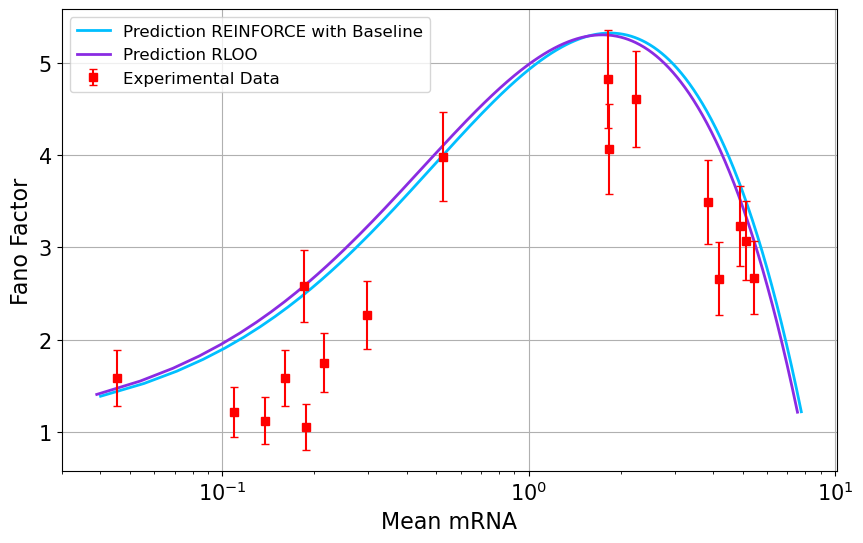

In [35]:
# Plot
plt.figure(figsize=(10, 6))
#plt.plot(mean_expression_dga, fano_factors_dga, label="Prediction DGA", linewidth=2, color ="violet")
plt.plot(mean_expression_b, fano_factors_b, label="Prediction REINFORCE with Baseline", linewidth=2, color ="deepskyblue")
plt.plot(mean_expression, fano_factors, label="Prediction RLOO", linewidth=2, color ="blueviolet")
plt.errorbar(mean_data, fano_factor_exp, yerr=std_fano, fmt='s', color='red', ecolor='red', capsize=3, label = "Experimental Data")
plt.xlabel("Mean mRNA", fontsize = 16)
plt.ylabel("Fano Factor", fontsize = 16)
plt.xscale('log')
plt.legend(fontsize = 12, loc = "upper left")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.savefig("rloo_5DL1.png", dpi=150)
plt.show()

## Second mRNA

In [89]:
# Load the data from file for lacUD5 promoter 
data=np.load("science_data_lacUD5.npy")

# Extract x and y data
x_data = data[:, 0]
y_data = data[:, 1]

# Get unique x values and their corresponding indices
unique_x, unique_indices = np.unique(x_data, return_index=True)

# Extract unique y values based on unique indices
unique_y = y_data[unique_indices]

# Create unique data array with x and y values
unique_data_lacUD5 = np.column_stack((unique_x, unique_y))

# Convert mean and variance data to torch tensors
mean_data_lacUD5 = torch.from_numpy(unique_data_lacUD5[:, 0]).double()
var_data_lacUD5 = mean_data_lacUD5 * torch.from_numpy(unique_data_lacUD5[:, 1]).double()

In [112]:
#parameters
# Set seed for reproducibility 
torch.manual_seed(40)

# Define simulation hyperparameters
num_iterations = 250
num_simulations = 50
sim_time = 0.2

poff_values = torch.nn.Parameter(torch.linspace(0.03, 0.97, len(unique_data_lacUD5)))
r = torch.nn.Parameter((1e+2) * torch.rand(1))
g = torch.nn.Parameter((1e+1) * torch.rand(1))
optimizer = optim.Adam([poff_values, r, g], lr = 0.01)

#save to file
filename1 = "RLOO_poff_lacUD5_250.txt"
filename2 = "RLOO_main_lacUD5_250.txt"
if os.path.exists(filename1):
    os.remove(filename1)
if os.path.exists(filename2):
    os.remove(filename2)

for iteration in tqdm(range(num_iterations)):
    optimizer.zero_grad()

    grad_poff = torch.zeros_like(poff_values)
    grad_r = torch.zeros_like(r)
    grad_g = torch.zeros_like(g)
    total_loss = 0.0

    for i in range(len(unique_data_lacUD5)):
        dp, dr, dg, loss = RLOO_estimate(poff_values[i], r, g, mean_data_lacUD5[i])
        grad_poff[i] = dp
        grad_r += dr
        grad_g += dg
        total_loss += loss

    grad_r /= len(unique_data_lacUD5)
    grad_g /= len(unique_data_lacUD5)
    total_loss /= len(unique_data_lacUD5)

    poff_values.grad = grad_poff
    r.grad = grad_r
    g.grad = grad_g

    torch.nn.utils.clip_grad_norm_([poff_values, r, g], max_norm=1.0)
    optimizer.step()

    # Clamp and sort as in original
    with torch.no_grad():
        r.clamp_(min=1.0)
        g.clamp_(min=1.0, max=r.item())
        poff_values.clamp_(min=0.01, max=0.98)
        poff_values.copy_(torch.sort(poff_values).values)

    # Save every iteration and print every 10
    if iteration % 10 == 0:
        print(f"Epoch {iteration}: Loss = {total_loss.item():.4f}")

    if iteration %1 == 0:
        write_to_file(filename2, iteration, r.item(), g.item(), r.item() / g.item(), total_loss.item())
        write_to_file(filename1, poff_values.tolist(), total_loss.item())


  0%|▏                                          | 1/250 [00:02<08:23,  2.02s/it]

Epoch 0: Loss = 16.2766


  4%|█▊                                        | 11/250 [00:20<07:28,  1.88s/it]

Epoch 10: Loss = 14.4903


  8%|███▌                                      | 21/250 [00:38<06:34,  1.72s/it]

Epoch 20: Loss = 13.4172


 12%|█████▏                                    | 31/250 [00:54<05:40,  1.56s/it]

Epoch 30: Loss = 12.3959


 16%|██████▉                                   | 41/250 [01:08<04:56,  1.42s/it]

Epoch 40: Loss = 11.5342


 20%|████████▌                                 | 51/250 [01:21<04:17,  1.29s/it]

Epoch 50: Loss = 11.4429


 24%|██████████▏                               | 61/250 [01:34<04:02,  1.28s/it]

Epoch 60: Loss = 11.0293


 28%|███████████▉                              | 71/250 [01:47<03:55,  1.32s/it]

Epoch 70: Loss = 10.3349


 32%|█████████████▌                            | 81/250 [02:00<03:39,  1.30s/it]

Epoch 80: Loss = 10.8026


 36%|███████████████▎                          | 91/250 [02:13<03:23,  1.28s/it]

Epoch 90: Loss = 11.0187


 40%|████████████████▌                        | 101/250 [02:26<03:15,  1.31s/it]

Epoch 100: Loss = 10.8445


 44%|██████████████████▏                      | 111/250 [02:39<03:01,  1.31s/it]

Epoch 110: Loss = 10.9084


 48%|███████████████████▊                     | 121/250 [02:52<02:47,  1.30s/it]

Epoch 120: Loss = 10.6842


 52%|█████████████████████▍                   | 131/250 [03:05<02:35,  1.30s/it]

Epoch 130: Loss = 10.4567


 56%|███████████████████████                  | 141/250 [03:18<02:22,  1.31s/it]

Epoch 140: Loss = 10.0206


 60%|████████████████████████▊                | 151/250 [03:32<02:08,  1.30s/it]

Epoch 150: Loss = 9.5056


 64%|██████████████████████████▍              | 161/250 [03:44<01:55,  1.29s/it]

Epoch 160: Loss = 9.8216


 68%|████████████████████████████             | 171/250 [03:57<01:43,  1.30s/it]

Epoch 170: Loss = 9.5104


 72%|█████████████████████████████▋           | 181/250 [04:10<01:30,  1.32s/it]

Epoch 180: Loss = 9.5089


 76%|███████████████████████████████▎         | 191/250 [04:23<01:14,  1.27s/it]

Epoch 190: Loss = 10.2301


 80%|████████████████████████████████▉        | 201/250 [04:36<01:03,  1.29s/it]

Epoch 200: Loss = 8.8223


 84%|██████████████████████████████████▌      | 211/250 [04:49<00:50,  1.31s/it]

Epoch 210: Loss = 9.0412


 88%|████████████████████████████████████▏    | 221/250 [05:02<00:37,  1.30s/it]

Epoch 220: Loss = 8.6714


 92%|█████████████████████████████████████▉   | 231/250 [05:15<00:24,  1.31s/it]

Epoch 230: Loss = 9.2367


 96%|███████████████████████████████████████▌ | 241/250 [05:28<00:11,  1.26s/it]

Epoch 240: Loss = 9.4556


100%|█████████████████████████████████████████| 250/250 [05:39<00:00,  1.36s/it]


In [131]:
data = np.loadtxt("RLOO_main_lacUD5_100.txt")
row_index = np.argmin(data[:, -1])
r_lacUD5 = data[row_index, 1]
g_lacUD5 = data[row_index, 2]

poff_values_lacUD5 = []
with open("RLOO_poff_lacUD5_100.txt", "r") as file:
    for line in file:
        list_str = line.rsplit(' ', 1)[0]
        list_str = list_str.strip('[').strip(']')
        str_values = list_str.split(',')
        row = [float(value) for value in str_values]
        poff_values_lacUD5.append(row)

poff_values_lacUD5 = poff_values_lacUD5[row_index][:len(unique_data_lacUD5)]

In [133]:
# Find the row index with minimum loss value. 
data_dga=np.loadtxt("learning_science_lacUD5_500.txt")
row_index_dga = np.argmin(data_dga[:, -1])
r_dga_lacUD5=data_dga[row_index_dga,1]
g_dga_lacUD5=data_dga[row_index_dga, 2]

# Path to poff_values
file_path_dga = 'learning_science_lacUD5_poff_500.txt'

# Initialize an empty list to store rows
poff_values_dga = []

with open(file_path_dga, 'r') as file:
    for line in file:
        # Remove the trailing number by splitting at the last space and taking the first part
        list_str = line.rsplit(' ', 1)[0]
        # Remove surrounding brackets
        list_str = list_str.strip('[').strip(']')
        # Split the remaining string by commas to form a list of strings
        str_values = list_str.split(',')
        # Convert strings to floats
        row = [float(value) for value in str_values]
        # Append the row to our data list
        poff_values_dga.append(row)
  
poff_values_dga = poff_values_dga[row_index_dga][:len(unique_data_lacUD5)] 

## Mean vs Fano Factor

### RLOO

In [137]:
#simulation data
r_best = r_lacUD5
g_best = g_lacUD5

poff_range = torch.linspace(0.003, 0.97, 500)

k_off = 1

mean_expression = []
fano_factors = []
for i in poff_range:
    k_on = (1.0 - i) / i
    m = k_off/(k_on + k_off) * r_best/g_best
    mean_expression.append(m)
    f = 1 + (k_on/(k_on + k_off)) * (r_best / (k_on + k_off+g_best))
    fano_factors.append(f)

#convert to numpy 
mean_expression = torch.tensor(mean_expression).detach().numpy()
fano_factors = torch.tensor(fano_factors).detach().numpy()

### DGA

In [140]:
#simulation data
poff_range_dga = torch.linspace(0.003, 0.97, 500)
k_off = 1

mean_expression_dga = []
fano_factors_dga = []
for i in poff_range_dga:
    k_on = (1.0 - i) / i
    m = k_off/(k_on + k_off) * r_dga_lacUD5/g_dga_lacUD5
    mean_expression_dga.append(m)
    f = 1 + (k_on/(k_on + k_off)) * (r_dga_lacUD5 / (k_on + k_off+g_dga_lacUD5))
    fano_factors_dga.append(f)


### Experimental Data

In [143]:
#experimental data
fano_factor_exp = var_data_lacUD5 / mean_data_lacUD5

# Calculate standard error for plotting (optional, adjust as needed)
std_mRNA = np.sqrt(mean_data_lacUD5)/np.sqrt(17)  # or from your data
std_fano = np.sqrt(fano_factor_exp)/np.sqrt(17)  # or from variance propagation

## Plot Graph

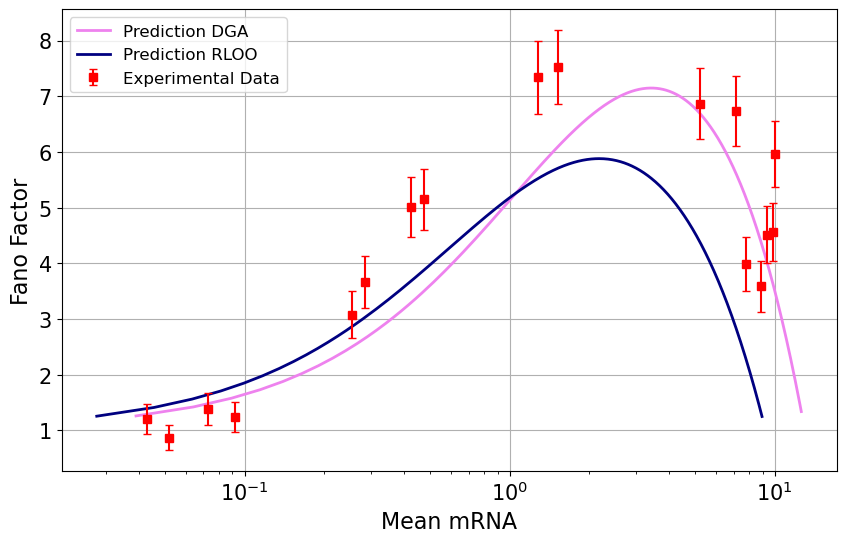

In [146]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(mean_expression_dga, fano_factors_dga, label="Prediction DGA", linewidth=2, color ="violet")
plt.plot(mean_expression, fano_factors, label="Prediction RLOO", linewidth=2, color ="navy")
plt.errorbar(mean_data_lacUD5, fano_factor_exp, yerr=std_fano, fmt='s', color='red', ecolor='red', capsize=3, label = "Experimental Data")
plt.xlabel("Mean mRNA", fontsize = 16)
plt.ylabel("Fano Factor", fontsize = 16)
plt.xscale('log')
plt.legend(fontsize = 12, loc = "upper left")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.savefig("RLOO_lacUD5.png", dpi=150)
plt.show()

# Standard Deviation of gamma and r

In [161]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define simulation hyperparameters
num_simulations = 200
sim_time = 0.2

def std_r(r, g, poff_values, RLOO_estimate, mean_data, unique_data, device='cpu', num_points=50, num_points2=50):
    loss_list = []

    # Generate a range of r values around the current value
    r_list = np.linspace(r - 0.8 * r, 2 * r, num_points)

    for r_value in r_list:
        r_tensor = torch.tensor([r_value], dtype=torch.float32, device=device)
        g_tensor = torch.tensor([g], dtype=torch.float32, device=device)
        poff_tensor = torch.tensor(poff_values, dtype=torch.float32, device=device)

        total_loss = 0.0

        for i in range(len(unique_data)):
            poff_i = poff_tensor[i].unsqueeze(0)
            mean_i = mean_data[i]

            _, _, _, loss = RLOO_estimate(poff_i, r_tensor, g_tensor, mean_i)
            total_loss += loss.item()

        avg_loss = total_loss / len(unique_data)
        loss_list.append(avg_loss)

    coeffs = np.polyfit(r_list, loss_list, deg=6)
    poly_func = np.poly1d(coeffs)
    second_derivative = np.polyder(poly_func, 2)

    evaluation_points = np.linspace(r_list[0], r_list[-1], num_points2)
    curvatures = [second_derivative(p) for p in evaluation_points]
    average_curvature = np.mean(curvatures)

    std_r_val = 1.0 / np.sqrt(abs(average_curvature))
    return std_r_val


def std_g(r, g, poff_values, RLOO_estimate, mean_data, unique_data, device='cpu', num_points=50, num_points2=50):
    loss_list = []

    g_list = np.linspace(g - 0.8 * g, 2 * g, num_points)

    for g_value in g_list:
        r_tensor = torch.tensor([r], dtype=torch.float32, device=device)
        g_tensor = torch.tensor([g_value], dtype=torch.float32, device=device)
        poff_tensor = torch.tensor(poff_values, dtype=torch.float32, device=device)

        total_loss = 0.0

        for i in range(len(unique_data)):
            poff_i = poff_tensor[i].unsqueeze(0)
            mean_i = mean_data[i]
            _, _, _, loss = RLOO_estimate(poff_i, r_tensor, g_tensor, mean_i)
            total_loss += loss.item()

        avg_loss = total_loss / len(unique_data)
        loss_list.append(avg_loss)

    coeffs = np.polyfit(g_list, loss_list, deg=6)
    poly_func = np.poly1d(coeffs)
    second_derivative = np.polyder(poly_func, 2)

    evaluation_points = np.linspace(g_list[0], g_list[-1], num_points2)
    curvatures = [second_derivative(p) for p in evaluation_points]
    average_curvature = np.mean(curvatures)

    std_g_val = 1.0 / np.sqrt(abs(average_curvature))
    return std_g_val

In [163]:
#values for 5DL1
std_r_RLOO = std_r(r_best, g_best, poff_values, RLOO_estimate, mean_data, unique_data)
std_g_RLOO = std_g(r_best, g_best, poff_values, RLOO_estimate, mean_data, unique_data)

/var/folders/l8/jw9zcbmd091129xbjrg49qbh0000gn/T/ipykernel_18178/1496171173.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  poff_tensor = torch.tensor(poff_values, dtype=torch.float32, device=device)
/var/folders/l8/jw9zcbmd091129xbjrg49qbh0000gn/T/ipykernel_18178/1496171173.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  poff_tensor = torch.tensor(poff_values, dtype=torch.float32, device=device)


In [164]:
#values for lacUD5
std_r_RLOO_lacUD5 = std_r(r_lacUD5, g_lacUD5, poff_values_lacUD5, RLOO_estimate, mean_data_lacUD5, unique_data_lacUD5)
std_g_RLOO_lacUD5 = std_g(r_lacUD5, g_lacUD5, poff_values_lacUD5, RLOO_estimate, mean_data_lacUD5, unique_data_lacUD5)

In [171]:
# for  5DL1
error_rloo = (r_best/g_best) * ((std_r_RLOO/r_best)**2 + (std_g_RLOO/g_best)**2)**0.5

# for lacUD5
error_rloo_lacUD5 = (r_lacUD5/g_lacUD5) * ((std_r_RLOO_lacUD5/r_lacUD5)**2 + (std_g_RLOO_lacUD5/g_lacUD5)**2)**0.5

In [173]:
print(error_rloo)

1.7814918891073566


In [175]:
print(error_rloo_lacUD5)

1.7810254165954216
